# Milestone 3; A Millenium of Battles

**TODO UPDATE**
[NBViewer](https://nbviewer.jupyter.org/github/ChristianMct/ADA2017-Homeworks/blob/master/project/milestone_2.ipynb)

## Tasks Description

Dec. 19, 2017 (23:59 CET): report (50%): a 4-page PDF document or a data story in a platform of your choice (e.g., a blog post, or directly in GitHub), plus the final notebook (continuation of milestone 2)

The tasks involving a large amount of data were pre-run and we simply describe their purposes and outputs while showing how to call them in comments.

## Outline
The notebook is organized as follow:

* **Notebook Setup**
* **Data Collection**
    1. **Page Extraction**
    2. **Fields Extraction**
    3. **Features Extraction**
* **Descriptive Analysis**
    1. **Geolocation**
    2. **Date**
    3. **Casualties**
    4. **Strength**
    5. **Combatants**
    6. **Results**
* **Exploratory Analysis an Results**
    1. **Strength vs. Casualties**
    2. **Casualties over time**
    3. **Duration of the battles over time**
    4. **Indiciviness of the battles over time**
    5. **Ranking of countries per years spent on battle fields**
    6. **Relation between the battle's features and its result**
    7. **Battles' results prediction based on features**



## Notebook Setup

In this part, we import the required packages and define functions (plotting, ...) that are used throughout this notebook.

In [1]:
import json
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import gmplot as gp
from folium.plugins import HeatMap
import folium as fl
from IPython.display import HTML
from IPython.display import display
from sklearn import linear_model
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import math
import re
import operator
from matplotlib.transforms import Bbox

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
FIGURES_FOLDER = "report/figures/"

In [3]:
def densplot(columns, xlabel, title, axo):
    for i,v in enumerate(columns):
        sns.distplot(v, ax=axo, kde_kws={"label": i})
    axo.set_title(title)
    axo.set_xlabel(xlabel, fontsize=12)
    
def scatplot(xelem, yelem, xlabel, ylabel, title, axo, polyfit=None, xlim=None, ylim=None):
    axo.scatter(xelem, yelem)
    if polyfit:
        axo.plot(np.unique(xelem), np.poly1d(np.polyfit(xelem, yelem, polyfit))(np.unique(xelem)), 'C2')
    if xlim:
        axo.set_xlim(0,xlim)
    if ylim:
        axo.set_ylim(0,ylim)
    axo.set_title(title)
    axo.set_xlabel(xlabel, fontsize=12)
    axo.set_ylabel(ylabel, fontsize=12)
    
def get_duration(battle):
    if battle.end_date == "None" or battle.end_date==battle.start_date:
        return 1
    else:
        return (datetime.datetime.strptime(battle.end_date, "%Y-%m-%d") - datetime.datetime.strptime(battle.start_date, "%Y-%m-%d")).days
    
def find_subtext(df, txt):
    contains = df.stack().str.match(txt).unstack()
    return contains[contains.any(1)].idxmax(1)

In [4]:
def get_year(date):
    return datetime.datetime.strptime(date, "%Y-%m-%d").year if date else None



## Data Collection

Data collection was a significant part of our work, given the nature of our original dataset. The task was to go from a 44 Gb wikipedia dump to clean and normalized features for each battle. As it was shown during the lecture, data collection is in fact an iterative process: new needs in the analysis step may require new data to be extracted, or different transformations to be applied. Thus, the data collection was organized into a **pipeline** of 3 operations, in order to achieve **composability** and **reproducibility**. This notebook is organized into sections according to the pipeline steps we followed. The actual code we used was split into **python modules**, which was much more suited for data processing than notebooks.

Each step of the pipeline is a **python script** in the `processing` folder. They have the following usage:

```shell
python script.py file-name-in file-name-out
```

For the sake of reproducibilty and organization, we used a naming convention for the output files. The latter includes the corresponding step of the pipline and the version of this dataset. Each version of the dataset is then associated with a git tag marking the state of the codebase that generated the file, to avoid confusion when coming back to the very begining of the pipeline each time we have a doubt (see README in the `datasets/` folder). We now describe each of the 3 pipeline operation.

### 1. Page Extraction

**Script**: `page_extraction.py`<br />
**Environmnent**: Cluster<br />
**Input**: `hdfs:///datasets/wikipedia/enwiki-latest-pages-articles-multistream.xml` (~44 Gb)<br />
**Output**: `battle-pages-v.json` (~123 Mb)<br />
**Description**:<br />
Pages extraction has two main goals, it selects what pages are (entirely) kept in the next step using a regular expression in the title (may be refined later, if we find a better way to isolate a battle related page), and translates it from an XML to a JSON representation for easier python processing. It leverages on [pySpark's DataFrame](https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html) and its custom [XML data-source from Databricks](https://github.com/databricks/spark-xml) to provide an SQL-like, parallelized Spark job.


### 2. Fields Extraction

**Script**: `fields_extraction.py`<br>
**Envir.**: Local<br>
**Output**: `battle-fields-v.json` (~14 Mb)<br>
**Description**:<br>
This step's purpose is to extract key-value pairs from the raw page [Wikitext](https://www.mediawiki.org/wiki/Wikitext), where keys are identifiers of information contained in the page and values are either a `dict` of other key-values pairs, a `list` of string, or a string (mainly, strings that are actually wikitext). In other words, we parse the page into a tree-like structure on which it will be easier to parse and extract actual features afterward. We mainly (but not exclusively) relied on the presence of an `infobox` [template](https://en.wikipedia.org/wiki/Help:Template) for most of the battle pages. Again, each line contains the tree of a battle. Therefore:

In [5]:
# We can load all the battle trees like this
battles_fields = [json.loads(line) for line in open('datasets/battle-fields-1.json')]
print("Number of pages or battles pages", len(battles_fields))

Number of pages or battles pages 27255


We then perform some preliminary assessments about the current state of the dataset.

In [6]:
errors = [b.get('infobox').get('error') for b in battles_fields]
no_infoboxes = sum([1 for e in errors if e=="no infobox"])
more_infoboxes = sum([1 for e in errors if e=="more than one infobox"])

print("Number of pages that do not contain an infobox ", no_infoboxes)
print("Number of pages that contains more than one infobox ", more_infoboxes)
print("Number of pages that do contain an infobox ", len(battles_fields)-no_infoboxes-more_infoboxes)

Number of pages that do not contain an infobox  19752
Number of pages that contains more than one infobox  17
Number of pages that do contain an infobox  7486


We immediately see that the number of pages we can extract information from is greately reduced. It later came out that many of the pages in the dump are aliases, redirects and discussion pages. However, the new battle count is still comfortably high to provide interesting analysis.

We then assess the actual population of the extractable keys, so that we know on what field we can focus our feature extraction effort:

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


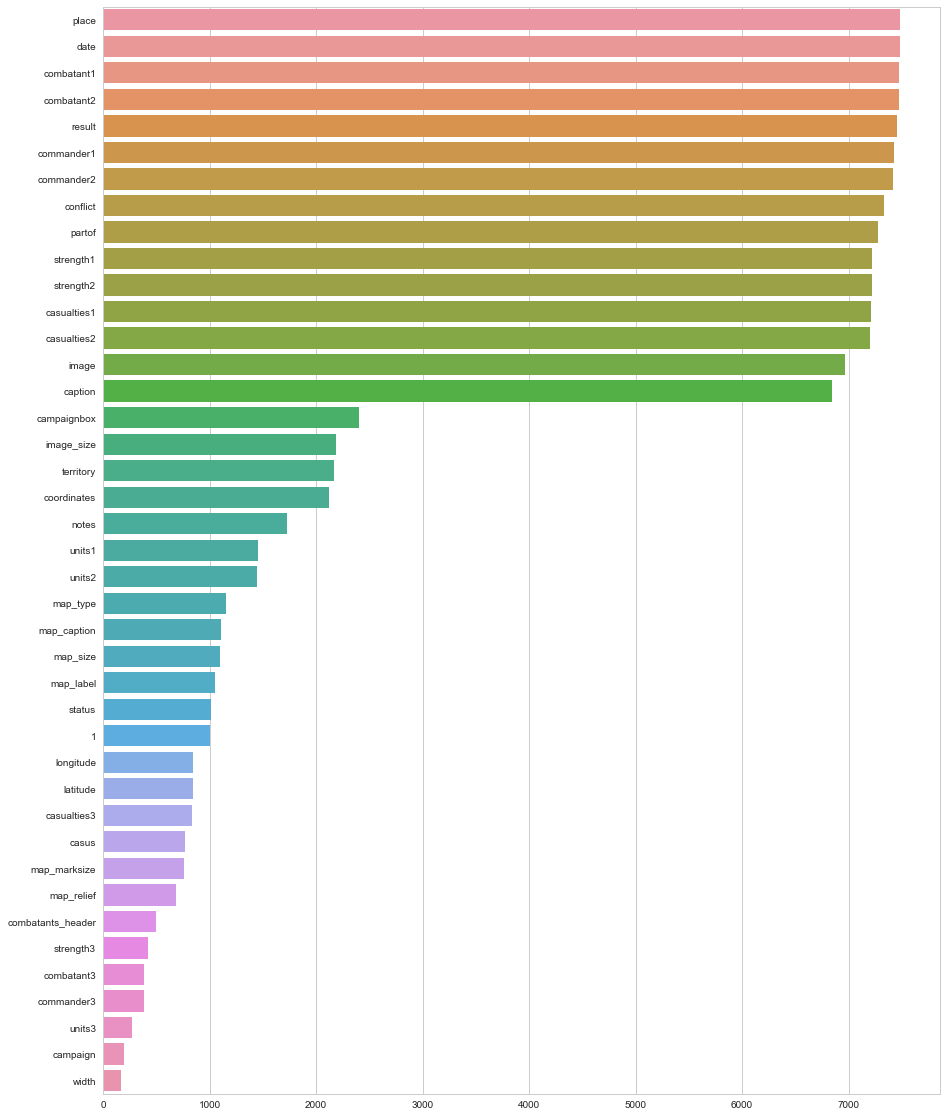

In [7]:
battles_fields = pd.DataFrame([b["infobox"] for b in battles_fields if not b["infobox"].get("error")])
f, ax = plt.subplots(figsize=(15, 20))
counts = battles_fields.count().sort_values(ascending=False)
counts = counts[counts > 100]
sns.barplot(x=counts, y=counts.index, ax=ax)
plt.show()

Based on these observations, we selected the following set of features to be extracted from the key-value pairs in the next pipeline step (we may add more of them later):
- date
- coordinates
- combatants (combatant1, ...)
- result
- strengths (strength1, ...) in terms of number of men
- casualties (casualties1, ...) in terms of number of men killed/wounded/captured

### 3. Features extraction

**Script**: `features_extraction.py`<br />
**Envir.**: Local<br />
**Output**: `battle-features-v.json` (~4.1 Mb)
**Description**:<br>
The final step extract a "flat" set of key-value from the preivious step's tree (i.e., values cannot be another `dict`) that we call features. It does so by first further parsing and transforming values from the previous step into a normalized representation, possibly combining multiple ones togheter. This was indeed the most time-consuming part of the current implementation, as it involves parsing sometime highly variable, unormalized free-text data. We elaborate on this aspect for some features in the following subsections. Each line of the output file contains the set of values for each feature, so it can be convieniently imported in a `pandas.DataFrame` object.

In [8]:
battles = pd.DataFrame([json.loads(line) for line in open("datasets/battle-features-2.json")])
battles["year"] = battles[battles.start_date.notnull()].start_date.apply(get_year)
print(battles.count())
demo_col = ["combatant_first_1", "combatant_first_2", "result_combatant_1", "result_combatant_2", "start_date", "end_date", "casualties_1", "casualties_2"]
battles[demo_col].head()

captured_1              7486
captured_2              7486
captured_3              7486
captured_4              7486
casualties_1            7486
casualties_2            7486
casualties_3            7486
casualties_4            7486
combatant_first_1       7205
combatant_first_2       7187
combatant_first_3         25
combatant_list_1        7486
combatant_list_2        7486
combatant_list_3        7486
end_date                2543
indecisive              7486
killed_1                7486
killed_2                7486
killed_3                7486
killed_4                7486
latitude                3766
longitude               3766
missing_1               7486
missing_2               7486
missing_3               7486
missing_4               7486
result_combatant_1      7486
result_combatant_2      7486
result_combatant_3      7486
source                  7486
start_date              6484
strategic_indecisive    7486
strength_1              7486
strength_2              7486
strength_3    

,combatant_first_1,combatant_first_2,result_combatant_1,result_combatant_2,start_date,end_date,casualties_1,casualties_2
0,Julius Caesar,Pompey,decisive victory,,None,None,230,10500
1,Royalists,Parliamentarians,victory,,1644-08-13,1644-09-02,0,0
2,United States,Empire of Japan,victory,,1944-09-15,1944-11-27,10786,10897
3,Athens,Persian Empire,,decisive victory,None,None,2000,5450
4,Austria,Electorate of Bavaria,decisive victory,,1704-08-13,None,12484,27190


## Descriptive analysis

We provide a succint descriptive analysis for the main features. 

### Geolocation

We begin by showing the geographical coverage of our dataset. This seems to be consistent with the location of wars across history.

In [9]:
battles_geo_date = battles[battles.start_date.notnull()]
battles_geo_date = battles_geo_date[(battles_geo_date.year>=1000) & (battles_geo_date.year <= 2018)]
decades = range(1000, 2018+10, 10)
centuries = range(1000, 2018+100, 100)
battles_geo_date["decade"] = pd.cut(battles_geo_date["year"], decades, labels=decades[:-1])
battles_geo_date["century"] = pd.cut(battles_geo_date["year"], centuries, labels=centuries[:-1])

In [10]:
b = battles_geo_date[battles_geo_date.year.between(1000, 1700)]
coord_df = b[["latitude", "longitude"]].dropna()
gmap = gp.GoogleMapPlotter(0,0,3)
gmap.heatmap(coord_df.latitude, coord_df.longitude)
#gmap.draw("1000.html")

b = battles_geo_date[battles_geo_date.year.between(1700, 1900)]
coord_df = b[["latitude", "longitude"]].dropna()
gmap = gp.GoogleMapPlotter(0,0,3)
gmap.heatmap(coord_df.latitude, coord_df.longitude)
#gmap.draw("1700.html")

b = battles_geo_date[battles_geo_date.year.between(1900, 2000)]
coord_df = b[["latitude", "longitude"]].dropna()
gmap = gp.GoogleMapPlotter(0,0,3)
gmap.heatmap(coord_df.latitude, coord_df.longitude)
#gmap.draw("1900.html")

b = battles_geo_date[battles_geo_date.year.between(2000, 2017)]
coord_df = b[["latitude", "longitude"]].dropna()
gmap = gp.GoogleMapPlotter(0,0,3)
gmap.heatmap(coord_df.latitude, coord_df.longitude)
#gmap.draw("2000.html")


#TODO SHOW THE PICTURES
HTML(filename='html/1000.html')
display(HTML(filename='html/1700.html'))
display(HTML(filename='html/1900.html'))
display(HTML(filename='html/2000.html'))


### Dates

We continue by looking at the time domain coverage and the battles distribution in time. It looks like we have a pretty uniform one in the sense that we have battle data to study over a large date range.

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'')

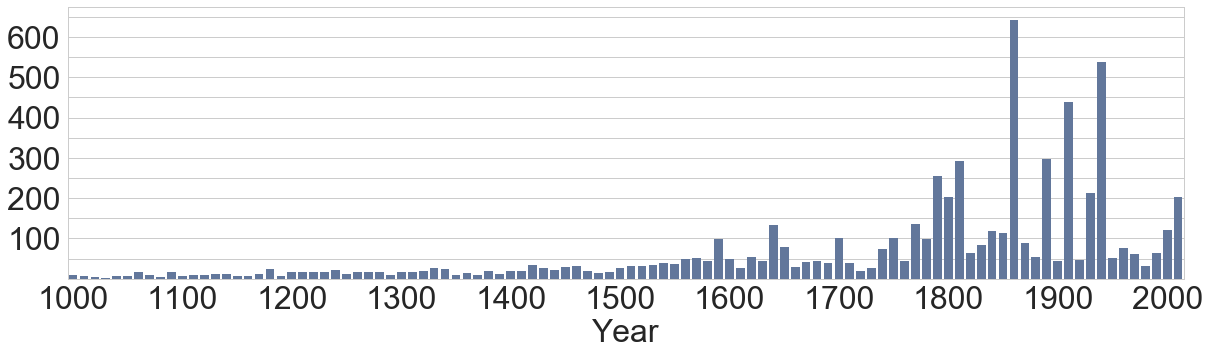

In [11]:
b = battles_geo_date.decade.value_counts(sort=False)
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(b.index, b, ax=ax, color="#5975A4")
ax.set_xticklabels([y if y in centuries else "" for y in b.index]);
ax.set_yticks(range(50, 700, 50))
ax.set_yticklabels([l if l%100==0 else "" for l in range(50, 700, 50)])
ax.tick_params(labelsize=32)
ax.set_xlabel("Year", fontsize=32)
ax.set_ylabel("", fontsize=1)

#fig.savefig("report/figures/temporal_coverage.eps", bbox_inches="tight")

#### Casualties

A battle has a maximum of 4 different combatant casualties ("casualties_1", "casualties_2", ...). And each casualties information can contain a number of people "killed", "wounded", "missing" or "captured". When possible, we also fetched (parsed) this data. We have observed that for multiple battles, wikipedia was referencing multiple sources for the same number and we handled this by doing the average of the values. We also did the average for range values. 

In [12]:
battles = pd.DataFrame(battles).replace(0, np.NaN)

In [13]:
battles[['killed_1', 'wounded_1', 'missing_1', 'captured_1', 'casualties_1']].head()

,killed_1,wounded_1,missing_1,captured_1,casualties_1
0,NaN,NaN,NaN,NaN,230.0
1,NaN,NaN,NaN,NaN,NaN
2,2336.0,8450.0,NaN,NaN,10786.0
3,2000.0,NaN,NaN,NaN,2000.0
4,4542.0,7942.0,NaN,NaN,12484.0


In [14]:
all_casualties = ['casualties_1', 'casualties_2', 'casualties_3', 'casualties_4']
battles[['killed_1', 'wounded_1', 'missing_1', 'captured_1', 'casualties_1', 'killed_2', 'wounded_2', 'missing_2', 'captured_2', 'casualties_2']].count()

killed_1        2689
wounded_1       1568
missing_1        248
captured_1       527
casualties_1    4392
killed_2        2694
wounded_2       1145
missing_2        181
captured_2       848
casualties_2    4496
dtype: int64

We observe that the casualties are sometimes defined by the number of killed and wounded people but we notice that most of the time, only the total number of casualties is available.
Thus, we focus on the total number of casualties for this descriptive analysis.

We observe that we were able to parse and retrieve numerical information for the casualties in almost 60% of the battles.

number of null values
casualties_1    3094
casualties_2    2990
casualties_3    7257
casualties_4    7481
dtype: int64
number of non null values
casualties_1    4392
casualties_2    4496
casualties_3     229
casualties_4       5
dtype: int64


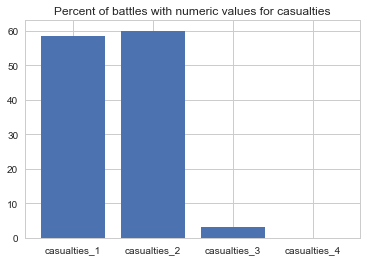

In [15]:
sums_null = battles[all_casualties].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(battles))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(battles)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We notice that *casualties_1* and *casualties_2*, corresponding to *combatant_1* and *combatant_2* have more data points than the others. This makes sense as most of the battles opposed two opponents.

Each casualties's feature has an average of:

In [16]:
averages = battles[all_casualties].mean()
print(averages)

casualties_1    4935.335838
casualties_2    8863.042482
casualties_3    4403.401747
casualties_4    1292.200000
dtype: float64


We can see that the average for 1 and 3 are close, while casualties_2's average is higher. This may indicate that usually the combatant 2 (to which corresponds casualties_2) is usually the looser of the battle. This can also be because casualties_2 contains more extreme values (outliers).
In the following, we observe the distributions of the features. Since casualties_4 only has 5 data points, we do not use it in our analysis. Moreover, we have observed similar distributions for the different features and thus only display for casualties_1.

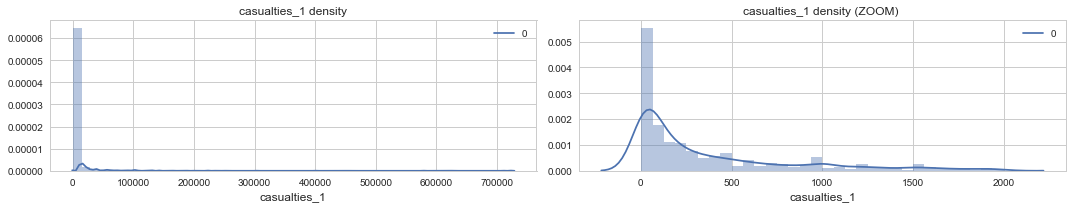

In [17]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,3))
densplot([battles['casualties_1'].dropna()], 'casualties_1', "casualties_1 density", ax1)
densplot([battles.query('2000 > casualties_1 >1')['casualties_1']], 'casualties_1', "casualties_1 density (ZOOM) ", ax2)
fig.tight_layout()
plt.show()

We observe that all casualties are pretty sparse in their values while they all have there peak for small casualties values. By "zooming", we observe that most of the values are between 0 and 2000 casualties. We also observe a very heavy tail that can explain the high averages observed before.

For the remaining of our analysis for this feature we will focus on casualties_1 (c1) and casualties_2 (c2).
We first observe that 3782 out of the 4392 (min(#casualties_1, #casualties_2)) battles have information on two combatants' casualties.

In [18]:
print("Number of battles with values for c1 and c2: ", (len(battles.query('0 < casualties_1 and 0 < casualties_2')['casualties_1'])))

Number of battles with values for c1 and c2:  3782


As a first step towards our future exploratory analysis, we can combine these two features, to see if, for example, high casualties for 1 combatant, means also high casualties for the other.

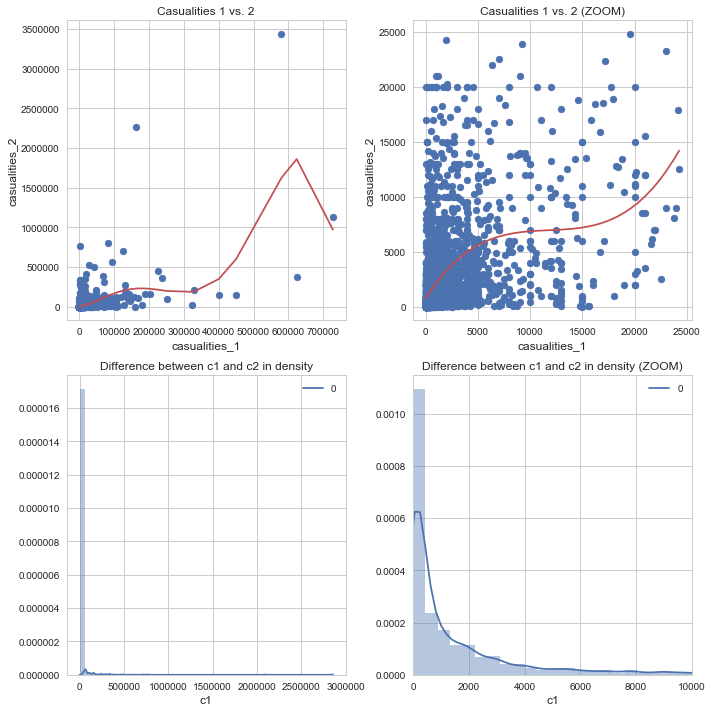

In [19]:
c1_zoom = battles.query('25000 > casualties_1 >1 and 25000 > casualties_2 > 1')['casualties_1']
c2_zoom = battles.query('25000 > casualties_1 >1 and 25000 > casualties_2 > 1')['casualties_2']

c1 = battles.query('casualties_1 >1 and casualties_2>1')['casualties_1']
c2 = battles.query('casualties_1 >1 and casualties_2>1')['casualties_2']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(10,10))
scatplot(c1, c2, 'casualities_1', 'casualities_2', "Casualities 1 vs. 2", ax1, 5)
scatplot(c1_zoom, c2_zoom, 'casualities_1', 'casualities_2', "Casualities 1 vs. 2 (ZOOM)", ax2, 3)
densplot([abs(c1-c2)], 'c1', "Difference between c1 and c2 in density", ax3)
densplot([abs(c1_zoom-c2_zoom)], 'c1', "Difference between c1 and c2 in density (ZOOM)", ax4)
ax4.set_xlim(0,10000)
fig.tight_layout()
plt.show()

We notice that the difference between the casualties is concentrated to 0. We cannot conclude that high casualties on one side means high casualties for the other side, even though it seems to be the case for less than 5000 casualties.

#### Strengths

Strength is the number of men involved in a battle. A battle has at maximum strength information for 3 different combatants ("strength_1", "strength_2", ...). When this information was presented as a range in the dataset, we did the average of the range boundaries.

In [20]:
all_strength = ['strength_1', 'strength_2', 'strength_3']
battles[all_strength].head()

,strength_1,strength_2,strength_3
0,22000.0,42500.0,NaN
1,NaN,NaN,NaN
2,47561.0,10900.0,NaN
3,9500.0,26000.0,NaN
4,52000.0,56000.0,NaN


We observe that the dataset contains a lot of NaN values. This is mainly because there is no numeric information for the strength. In our data extraction pipeline we have observed that strength_1 and strength_2 contain only 120 and 110 lines (battles) that have a numeric information but cannot be parsed. (it can also be the case that it is irrelevant numeric information, thus it is purposely not parsed).

number of null values
strength_1    2324
strength_2    2382
strength_3    7472
dtype: int64
number of non null values
strength_1    5162
strength_2    5104
strength_3      14
dtype: int64


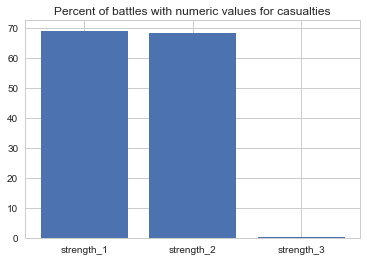

In [21]:
sums_null = battles[['strength_1', 'strength_2', 'strength_3']].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(battles))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(battles)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We observe that almost 70% of the battles have numeric values for two combatants ("strength_1" and "strength_2"). We also notice that strength_1 and 2 have more data points than the other. Again, this makes sense as we can usually consider two opposite sides in a battle.
Each strength feature has an average of:

In [22]:
averages_strength = battles[all_strength].mean()
print(averages_strength)

strength_1    19714.607129
strength_2    21019.709835
strength_3    20321.142857
dtype: float64


We can see that the average for the 3 features is pretty similar. This may indicate that usually the battles oppose two sides that have a similar number of fighters.
We observe the distributions of the features: (Again we will focus on the first two as the last one only has 14 data points)

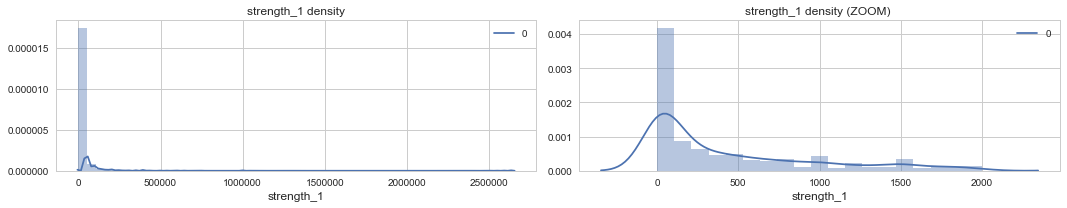

In [23]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,3))
densplot([battles['strength_1'].dropna()], 'strength_1', "strength_1 density", ax1)
densplot([battles.query('2000 > strength_1 >1')['strength_1']], 'strength_1', "strength_1 density (ZOOM) ", ax2)

fig.tight_layout()
plt.show()

We observe similar results as for casualties. In fact strength 1,2 and 3 are all pretty sparse (we only display for strength_1) in their values while they all have their peak for small strength values. By "zooming", we observe that most of the values are between 0 and 2000 for strength.

For the remaining of our analysis for this feature we will focus on strength_1 (s1) and strength_2 (s2).
We first observe that 4383 out of the 5104 (min(#strength_1, #strength_2)) battles have information on two combatants' strengths.

In [24]:
print("number of battles with values for s1 and s2: ", (len(battles.query('1 < strength_1 and strength_2 > 1')['strength_1'])))

number of battles with values for s1 and s2:  4383


We now combine these two features, to see if, for example, high strength for 1 combatant, means also high strength for the other, as the average and distribution results tend to show.

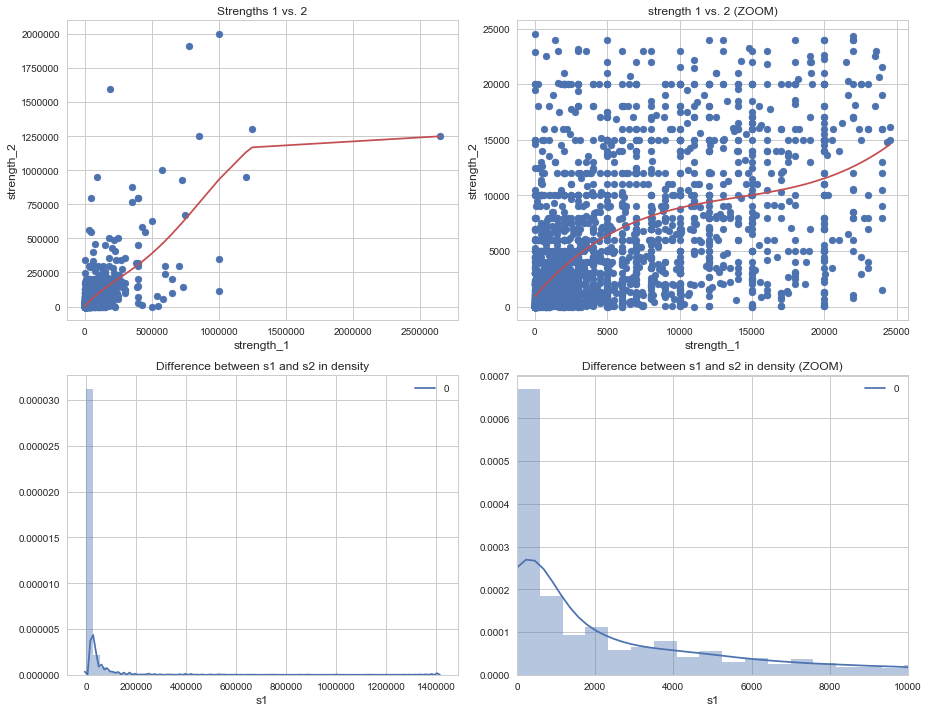

In [25]:
s1_zoom = battles.query('25000 > strength_1 >1 and 25000 > strength_2 > 1')['strength_1']
s2_zoom = battles.query('25000 > strength_1 >1 and 25000 > strength_2 > 1')['strength_2']

s1 = battles.query('strength_1 >1 and strength_2>1')['strength_1']
s2 = battles.query('strength_1 >1 and strength_2>1')['strength_2']


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(13,10))
scatplot(s1, s2, 'strength_1', 'strength_2', "Strengths 1 vs. 2", ax1, 5)
scatplot(s1_zoom, s2_zoom, 'strength_1', 'strength_2', "strength 1 vs. 2 (ZOOM)", ax2, 3)
densplot([abs(s1-s2)], 's1', "Difference between s1 and s2 in density", ax3)
densplot([abs(s1_zoom-s2_zoom)], 's1', "Difference between s1 and s2 in density (ZOOM)", ax4)
ax4.set_xlim(0,10000)
fig.tight_layout()
plt.show()

These first results tend to show that usually the battles oppose two sides with a close strength. Indeed, the difference between the two strength is usually small. We also observe that, the number seems to be often rounded up in wikipedia by looking at the top right graph where we can see kind of grid patterns.

#### Combatants

A battle has at maximum 3 different combatants ("combatant_1", "combatant_2", ...). We notice that wikipedia often contains multiple combatants in one combatant feature. For example, during the world war, the battles usually opposed two sides while each side was made of an alliance of multiple combatants. Thus, we retrieve the main combatant and a list of all the combatants present for each battle for each feature.

In [26]:
all_combatant = ['combatant_first_1', 'combatant_list_1', 'combatant_first_2', 'combatant_list_2']
battles[all_combatant].head()

,combatant_first_1,combatant_list_1,combatant_first_2,combatant_list_2
0,Julius Caesar,"[Julius Caesar, Populares]",Pompey,"[Pompey, Optimates]"
1,Royalists,[Royalists],Parliamentarians,[Parliamentarians]
2,United States,[United States],Empire of Japan,[Empire of Japan]
3,Athens,"[Athens, Plataea]",Persian Empire,[Persian Empire]
4,Austria,"[Austria, Prussia, Hesse-Kassel, Hesse-Homburg...",Electorate of Bavaria,"[Electorate of Bavaria, Kingdom of France, Bav..."


number of null values
combatant_first_1     281
combatant_first_2     299
combatant_first_3    7461
dtype: int64
number of non null values
combatant_first_1    7205
combatant_first_2    7187
combatant_first_3      25
dtype: int64


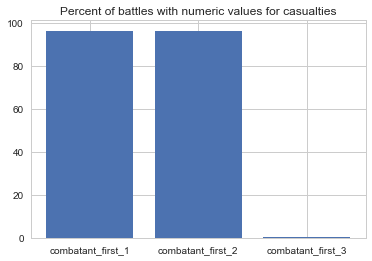

In [27]:
sums_null = battles[['combatant_first_1', 'combatant_first_2', 'combatant_first_3']].isnull().sum()
sums_non_null_percent = 100-(100*sums_null/len(battles))
print("number of null values")
print(sums_null)
print("number of non null values")
print(len(battles)-sums_null)
plt.bar(range(len(sums_null)), sums_non_null_percent)
plt.title("Percent of battles with numeric values for casualties")
plt.xticks(range(len(sums_null)), sums_null.keys())
plt.show()

We observe that as oppososed to the previous features, most of the battles contain information about the combatants. Again most of the battles are between two (group of) combatants.

Since the number of different combatants is pretty high: 4719. We will show here the 50 combatants that participated in the higher number of battles. And not surprisingly (!), the U.S. are first, right before France and Spain.

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[]

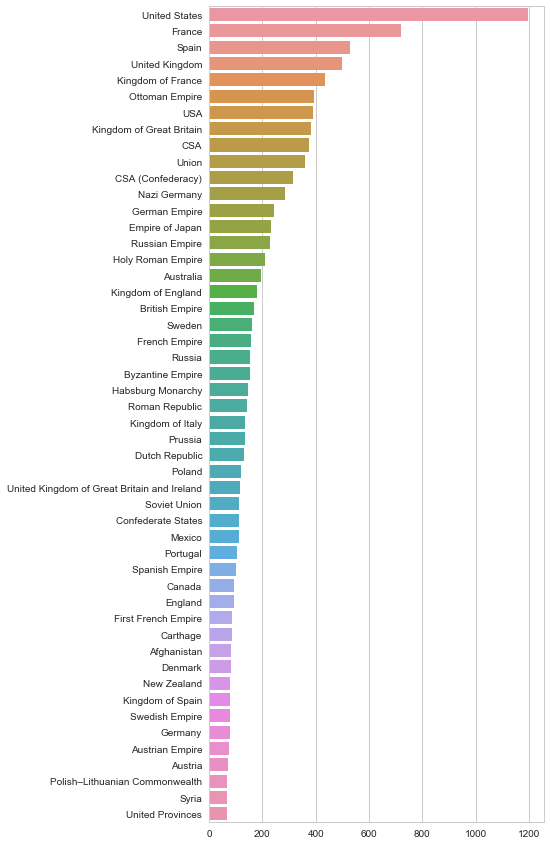

In [28]:
cbt_1 = np.array(battles["combatant_list_1"].dropna())
cbt_2 = np.array(battles["combatant_list_2"].dropna())
cbt_3 = np.array(battles["combatant_list_3"].dropna())

cbt_all = np.concatenate((cbt_1, cbt_2, cbt_3))

all_cbt_names = [c for cl in cbt_all for c in cl]
names = pd.Series(all_cbt_names)

f, ax = plt.subplots(figsize=(6, 15))
counts = names.value_counts().sort_values(ascending=False)
counts = counts.head(50)
sns.barplot(x=counts, y=counts.index, ax=ax)
plt.plot()

#### Results

When parsing the battles' results, we mapped them to a qualifier and a result type.
A qualifier can be: "decisive", "major", "crushing", "tactical" or "strategic", while the result type is in: "victory", "defeat", "retreat".
The results correspond then to each combatant (or group of combatant).

In [29]:
all_results = ['result_combatant_1','result_combatant_2','result_combatant_3', 'indecisive', 'tactical_indecisive', 'strategic_indecisive']
battles[all_results].head()

,result_combatant_1,result_combatant_2,result_combatant_3,indecisive,tactical_indecisive,strategic_indecisive
0,decisive victory,,,False,False,False
1,victory,,,False,False,False
2,victory,,,False,False,False
3,,decisive victory,,False,False,False
4,decisive victory,,,False,False,False


/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


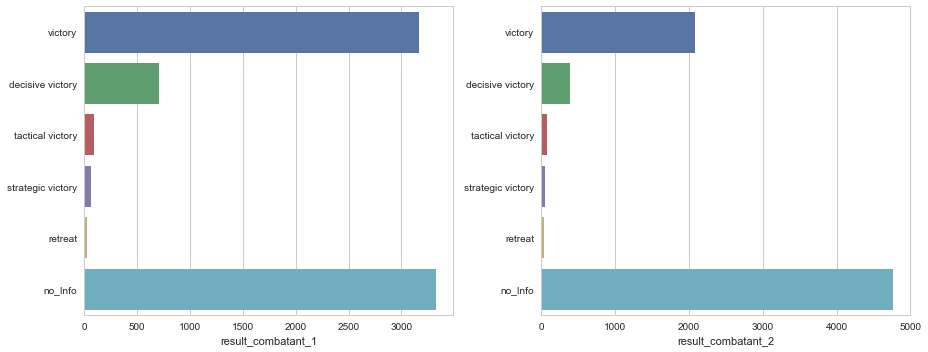

In [30]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,5))
counts1 = battles['result_combatant_1'].value_counts().sort_values(ascending=False)
counts1 = counts1.head(6)
counts1["no_Info"] = counts1[""]
del counts1[""]
sns.barplot(x=counts1, y=counts1.index, ax=ax1)
counts2 = battles['result_combatant_2'].value_counts().sort_values(ascending=False)
counts2 = counts2.head(6)
counts2["no_Info"] = counts2[""]
del counts2[""]
sns.barplot(x=counts2, y=counts2.index, ax=ax2)
fig.tight_layout()

We observe that for each feature, the number of empty values (no_info) is high (about 45% of the dataset for *combatant_1*).
We also observe that the most present type is victory, while the qualifier of the victory is precised in some cases.

We check for inconsistencies, e.g. two opposite sides with victory as a result. And only found 63 out of more thant 7000 battles.

In [31]:
print("Inconsistencies: ", len(battles.loc[battles["result_combatant_1"].str.contains('icto') & battles["result_combatant_2"].str.contains('icto')]))

Inconsistencies:  62


## Exploratory Analysis And Results

1. **Strength vs. Casualties**
2. **Casualties over time**
3. **Duration of the battles over time**
4. **Indiciviness of the battles over time**
5. **Ranking of countries per years spent on battle fields**
6. **Relation between the battle's features and its result**
7. **Battles' results prediction based on features**
       
In this exploratory analysis, we chose to show only the correlations and relations that are interesting in order to understand the general picture behind the data and to answer our research questions.

### 1. Strength vs. Casualties

In this part, we study the correlation between strength (number of soldiers) and the number of casualties. We make the hypothesis that the casualties should be positively correlated with the strength.

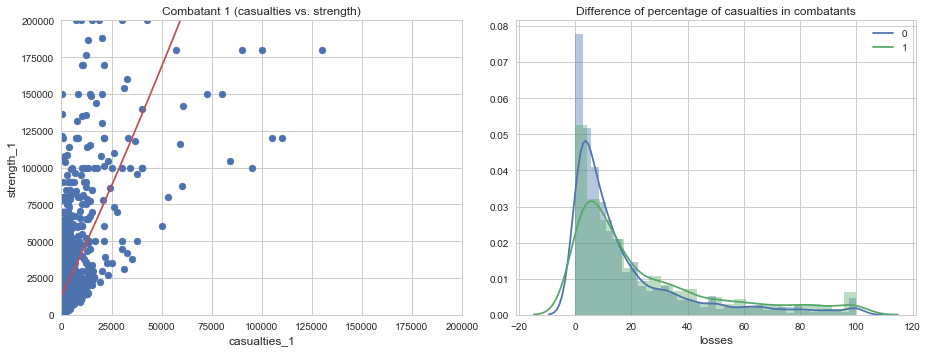

In [32]:
strenCasu_battles = battles.query('casualties_1 >1 and casualties_2 >1 and strength_1 >1 and strength_2 >1')
strenCasu_battles = strenCasu_battles.query('casualties_1 <= strength_1 and casualties_2 <= strength_2')
strenCasu_battles['casustren1'] = strenCasu_battles["casualties_1"]*100/strenCasu_battles["strength_1"]
strenCasu_battles['casustren2'] = strenCasu_battles["casualties_2"]*100/strenCasu_battles["strength_2"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,5))
scatplot(strenCasu_battles['casualties_1'], strenCasu_battles['strength_1'], 'casualties_1', 'strength_1', "Combatant 1 (casualties vs. strength)", ax1, 3, 200000, 200000)
densplot([strenCasu_battles['casustren1'], strenCasu_battles['casustren2']], "losses", "Difference of percentage of casualties in combatants", ax2)
fig.tight_layout()
plt.show()

We first removed the inconsistencies, where a combatant had more casualties than soldiers. Then, we noticed that the correlations between casualties and strength were similar for both combatants thus we only show it for one. In the first graph, we observe that our hypothesis is verified and that casualties and strength are positiviely correlated. In the second graph, we observe the distribution of the percentage of casualties. Thankfully for the soldiers, this distribution is concentrated at the small values.

### 2. Casualties over time
We study here how the number of casualties evolves in time. We have noticed in our descriptive analysis that the casualties numbers distribution was skewed with a concentration on small values and a heavy tail. We show here that the distribution of the log of these numbers is close to a gaussian and we study the evolution of the percentage of casualties.

In [33]:
time_battles = pd.DataFrame(battles).replace(0, np.NaN)
time_battles = time_battles[time_battles.start_date.notnull()]
time_battles.fillna(value="None", inplace=True)
time_battles["year"] = time_battles["start_date"].apply(get_year)
time_battles = time_battles[(time_battles.year>=1000) & (time_battles.year <= 2018)]
time_battles["duration"] = [get_duration(battle) for _, battle in time_battles.iterrows()]
time_battles["log_duration"] = np.log10(time_battles.duration)
decades = range(int(time_battles.year.min()), int(time_battles.year.max())+10, 10)
centuries = range(int(time_battles.year.min()), int(time_battles.year.max())+100, 100)
time_battles["decade"] = pd.cut(time_battles["year"], decades, labels=decades[:-1])
time_battles["century"] = pd.cut(time_battles["year"], centuries, labels=centuries[:-1])

Text(0.5,1,'Frequency of Number of Casualties on a base 10 logarithm scale on the entire dataset')

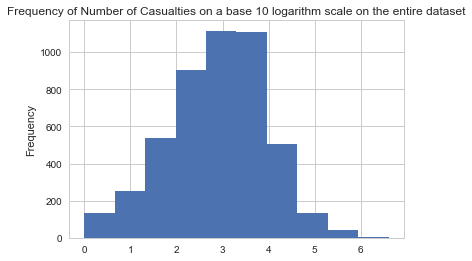

In [34]:
time_battles.casualties_1.replace(to_replace='None', value=0, inplace=True)
time_battles.casualties_2.replace(to_replace='None', value=0, inplace=True)
time_battles.casualties_3.replace(to_replace='None', value=0, inplace=True)
time_battles.casualties_4.replace(to_replace='None', value=0, inplace=True)
time_battles["casualties"] = time_battles.casualties_1 + time_battles.casualties_2 + time_battles.casualties_3 + time_battles.casualties_4
time_battles.casualties.replace(to_replace=0, value=np.nan, inplace=True)
time_battles["log_casualties"] = np.log10(time_battles.casualties)
time_battles.log_casualties.plot.hist()
plt.title('Frequency of Number of Casualties on a base 10 logarithm scale on the entire dataset')

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


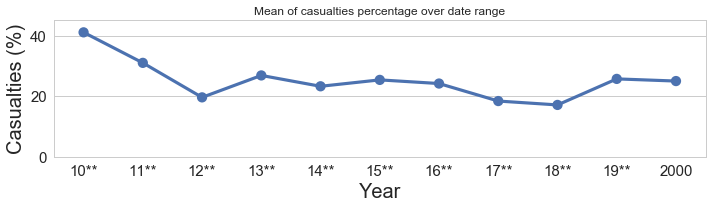

In [35]:
strenCasu_battles['CasualtiesPercent'] = ((strenCasu_battles['casualties_1']*100/strenCasu_battles['strength_1'])+(strenCasu_battles['casualties_2']*100/strenCasu_battles['strength_2']))/2
strenCasu_battles["decade"] = pd.cut(strenCasu_battles["year"], decades, labels=decades[:-1])
strenCasu_battles["century"] = pd.cut(strenCasu_battles["year"], centuries, labels=centuries[:-1])
bdec = strenCasu_battles.groupby('century').CasualtiesPercent.mean().dropna()

fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,3), sharey=False)
sns.set_style("whitegrid")
sns.pointplot(x=np.array(bdec.index), y=np.array(bdec), ax=ax1)
ax1.set_ylabel('Casualties (%)', fontsize=20)
ax1.set_xlabel('Year', fontsize=20)
ax1.set_ylim(0,45)
ax1.set(xticklabels=['10**','11**','12**','13**','14**','15**','16**','17**','18**','19**','2000'])
ax1.set_title('Mean of casualties percentage over date range')
ax1.tick_params(labelsize=15)
fig.tight_layout()
#fig.savefig(FIGURES_FOLDER+'CasuPerCent.eps')

As explained in the report, the number of casualties is sensibly going down but is pretty stable.

### 3. Duration of the battles over time

We observe now how the duration of the battles evolved since year 1000.

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


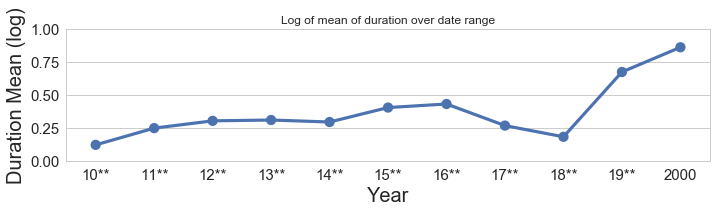

In [41]:
fig, ax1 = plt.subplots(figsize=(10,3), sharey=True)
sns.set(color_codes=True)
bdec = time_battles.groupby('century').log_duration.mean().dropna()

sns.set_style("whitegrid")
sns.pointplot(x=np.array(bdec.index), y=np.array(bdec), ax=ax1)
ax1.set_ylabel('Duration Mean (log)', fontsize=20)
ax1.set_xlabel('Year', fontsize=20)
ax1.tick_params(labelsize=15)
ax1.set(xticklabels=['10**','11**','12**','13**','14**','15**','16**','17**','18**','19**','2000'])
ax1.set_title('Log of mean of duration over date range')
ax1.set_ylim(0,1)
fig.tight_layout()
#fig.savefig(FIGURES_FOLDER+'durThByCent.eps')

We observe that the duration is increasing. Again, we discuss this in our report by for example noticing that the duration is increasing while the number of casualties remain stable.

### 4. Indiciviness of the battles over time

We show in this part that battles are more and more strategic and tactical. Thus, the result of a battle is more rarely decisive and most of the time a battle is serving a bigger goal.

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


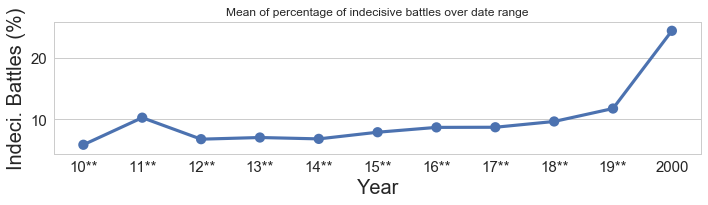

In [42]:
decades = range(int(battles.year.min()), int(battles.year.max())+10, 10)
centuries = range(int(battles.year.min()), int(battles.year.max())+100, 100)

indeci_battle = time_battles[((time_battles.result_combatant_1 == "") & (time_battles.result_combatant_2 == "")) | time_battles.indecisive]

inccent = indeci_battle.groupby("century").title.count()/time_battles.groupby("century").title.count()

fig, ax1 = plt.subplots(1, 1, figsize=(10,3))
sns.pointplot(x=np.array(inccent.index), y=inccent*100, ax=ax1)
ax1.set_ylabel('Indeci. Battles (%)', fontsize=20)
ax1.set_xlabel('Year', fontsize=20)
ax1.set(xticklabels=['10**','11**','12**','13**','14**','15**','16**','17**','18**','19**','2000'])
ax1.set_title('Mean of percentage of indecisive battles over date range')
ax1.tick_params(labelsize=15)
fig.tight_layout()
#fig.savefig(FIGURES_FOLDER+'indThByCent.eps')

### 5. Ranking of countries per years spent on battle fields

In this part, we observe that France is the country that fought the most in history. We also display the ranking of the top-10 "fighters". Moreover, we observe that since their creation, the United States is the country fighting the most with a very high percentage of its history spent on battle fields.

In [38]:
rank_battles = pd.DataFrame(battles).replace(0, np.NaN)
rank_battles = rank_battles[rank_battles.start_date.notnull()]
rank_battles.fillna(value="None", inplace=True)

rank_battles["year"] = rank_battles["start_date"].apply(get_year)

rank_battles = rank_battles[(rank_battles.year>=1000) & (rank_battles.year <= 2018)]

rank_battles["duration"] = [get_duration(battle) for _, battle in rank_battles.iterrows()]

/anaconda3/envs/ada/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


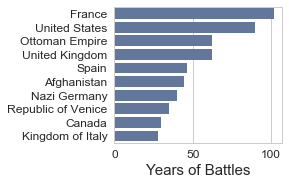

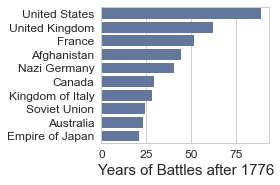

In [39]:
count = dict()
countModern = dict()
for i,v in enumerate(rank_battles['combatant_list_1']):
    combatants = list()
    combatants.append(v)
    combatants.append(rank_battles.iloc[i]['combatant_list_2'])
    combatants.append(rank_battles.iloc[i]['combatant_list_3'])
    for j,w in enumerate(combatants):
        for k,x in enumerate(w):
            if x == 'USA' or x=='Confederate States' or x == 'CSA (Confederacy)' :
                x = 'United States'
            if x == 'Kingdom of France':
                x = 'France'
            x = re.sub('(Flag of|.svg|.png)', '', x)
            
            if x in count:
                count[x] += int(rank_battles.iloc[i]['duration'])
            else:
                count[x] = int(rank_battles.iloc[i]['duration'])

            if rank_battles.iloc[i]['year'] > 1775: 
                if x in countModern:
                    countModern[x] += int(rank_battles.iloc[i]['duration'])
                else:
                    countModern[x] = int(rank_battles.iloc[i]['duration'])
for k in count.keys():
    count[k] = int(count[k])/365
sorted_count = sorted(count.items(), key=operator.itemgetter(1), reverse=True)

for kModern in countModern.keys():
    countModern[kModern] = int(countModern[kModern])/365
sorted_countModern = sorted(countModern.items(), key=operator.itemgetter(1), reverse=True)

key, value = zip(*sorted_count[0:10])
fig, ax1 = plt.subplots(figsize=(3,2.5))
ax1 = sns.barplot(y=list(key), x=list(value), color="#5975A4")
ax1.set_xlabel("Years of Battles", fontsize=15)
ax1.tick_params(labelsize=12)
fig.savefig(FIGURES_FOLDER+'YearsFightingRanking.eps', bbox_inches='tight')

keyModern, valueModern = zip(*sorted_countModern[0:10])
figModern, ax1 = plt.subplots(figsize=(3,2.5))
ax1 = sns.barplot(y=list(keyModern), x=list(valueModern), color="#5975A4")
ax1.set_xlabel("Years of Battles after 1776", fontsize=15)
ax1.tick_params(labelsize=12)
figModern.savefig(FIGURES_FOLDER+'YearsFightingRankingModern.eps', bbox_inches='tight')

In [40]:

df_USAFights = rank_battles
df_USAFights = df_USAFights.assign(isUSA=(find_subtext(df_USAFights, '(United States|USA|Confederate|CSA)')))
df_USAFights = df_USAFights[df_USAFights.start_date.notnull() & df_USAFights.isUSA.notnull()]
for i,v in enumerate(df_USAFights['duration']):
    years = 1
    if v > 365:
        years = int(v/365)+1
    for j in range(1,years+1):
        df_USAFights = df_USAFights.append({'year': int(df_USAFights.iloc[i]['year'])+1}, ignore_index=True)
        
X = df_USAFights["year"]
fig, ax = plt.subplots(figsize=(20,3))
ax.scatter(X, [1]*len(X),
           marker='|',linewidth=5, s=1000)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label('Year')
ax.set_xlabel('Year', fontsize=25)
ax.tick_params(labelsize=25)
ax.get_yaxis().set_ticklabels([])
plt.xlim(1750, 2018)
plt.show()
#fig.savefig(FIGURES_FOLDER+'USAFighting.eps', bbox_inches='tight')

TypeError: reduction operation 'argmax' not allowed for this dtype

In [ ]:
print("The USA spent ", len(X.value_counts()), " years in which they were involved in at least one battle")

### 6. Relation between the battle's features and its result

We want to study the link between the battle's features and the result of a battle, e.g., the relation between the number of casualties on each side, which side won and the type of this victory.


In [ ]:
def casualtiesAndVictory(df, text):
    nbrOfVictories = len((df.loc[(df["result_combatant_1"].str.contains(text) & (df["casualties_1"]>df["casualties_2"])) | (df["result_combatant_2"].str.contains(text) & (df["casualties_2"]>df["casualties_1"]))]))
    nbrTotal = len((df.loc[(df["result_combatant_1"].str.contains(text)) | (df["result_combatant_2"].str.contains(text))]))
    nbrOfVictoriesPer = nbrOfVictories*100/nbrTotal
    return (100-nbrOfVictoriesPer)

def strengthAndVictory(df, text):
    nbrOfVictories = len((df.loc[(df["result_combatant_1"].str.contains(text) & (df["strength_1"]<df["strength_2"])) | (df["result_combatant_2"].str.contains(text) & (df["strength_2"]<df["strength_1"]))]))
    nbrTotal = len((df.loc[(df["result_combatant_1"].str.contains(text)) | (df["result_combatant_2"].str.contains(text))]))
    nbrOfVictoriesPer = nbrOfVictories*100/nbrTotal
    return (100-nbrOfVictoriesPer)

def bothAndVictory(df, text):
    nbrOfVictories = len((df.loc[((df["result_combatant_1"].str.contains(text) & (df['casustren1'] > df['casustren2'])) | (df["result_combatant_2"].str.contains(text) & (df['casustren2']>df['casustren1'])))]))
    nbrTotal = len((df.loc[(df["result_combatant_1"].str.contains(text)) | (df["result_combatant_2"].str.contains(text))]))
    nbrOfVictoriesPer = nbrOfVictories*100/nbrTotal
    return (100-nbrOfVictoriesPer)

#plot construction
strengthBased = strengthAndVictory(strenCasu_battles,'icto')
strengthBasedDecisive = strengthAndVictory(strenCasu_battles,'decisive')
strengthBasedStrategic = strengthAndVictory(strenCasu_battles,'strategic')
strengthBasedTactical = strengthAndVictory(strenCasu_battles,'tactical')

casualtiesBased = casualtiesAndVictory(strenCasu_battles,'icto')
casualtiesBasedDecisive = casualtiesAndVictory(strenCasu_battles,'decisive')
casualtiesBasedStrategic = casualtiesAndVictory(strenCasu_battles,'strategic')
casualtiesBasedTactical = casualtiesAndVictory(strenCasu_battles,'tactical')

casualtiesStrengthBased = bothAndVictory(strenCasu_battles,'icto')
casualtiesStrengthBasedDecisive = bothAndVictory(strenCasu_battles,'decisive')
casualtiesStrengthBasedStrategic = bothAndVictory(strenCasu_battles,'strategic')
casualtiesStrengthBasedTactical = bothAndVictory(strenCasu_battles,'tactical')


y = [strengthBased, strengthBasedDecisive, strengthBasedStrategic, strengthBasedTactical, casualtiesBased, casualtiesBasedDecisive, casualtiesBasedStrategic, casualtiesBasedTactical, casualtiesStrengthBased, casualtiesStrengthBasedDecisive, casualtiesStrengthBasedStrategic, casualtiesStrengthBasedTactical]

# plot
fig, ax = plt.subplots(figsize=(10,5))
width = 0.25
colors = ['lightcoral','darkseagreen', '#5975A4', 'g']
shift=0
for i, v in enumerate(y):
    if i%4 == 0:
        shift = shift+1
    else:
        shift = shift+(width+0.01)

    down = plt.bar(shift, v, width, color=colors[i%4])

maj_ticks = [1.4, 3.2, 5]
ax.set_xticks(maj_ticks)

ax.set_xticklabels(["Strength", "Casualties", "Casualties per strength (%)"], fontsize=15)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylim(0,100)
ax.set_ylabel('Victory (%)', fontsize=20)
ax.tick_params(labelsize=15)
plt.legend(['Any', 'Decisive', 'Strategic', 'Tactical'], loc='upper left', fontsize=15, frameon=True)
fig.tight_layout()
#fig.savefig(FIGURES_FOLDER+'VictoryAdvantage.eps')

As discussed in the report, the victory or not of a combatant seems to mainly depend on the number of casualties. Meaning that the combatant with the more casualties most of the time, or more precisely in almost 80% of the cases, looses. We also discuss the interesting disctinction between the victory types and their link with other features in the report.

### 7. Battles' results prediction based on features

In this section, we aim at building a classifier in order to predict a battle's result depending on features.
Namely, from the number of casualties of each opponent and their respective strength, we wish to find the victorious combatant. The way we procede is by asking our classifier to predict if the first combatant is the winner or not.

In [ ]:
strenCasu_battles["win"]=0
features = ["casualties_1", "casualties_2",'strength_1', 'strength_2', 'combatant_first_1', 'combatant_first_2']
results_features = ['result_combatant_1', 'result_combatant_2']
results_features.append('win')
y = ['win']
strenCasu_battles.loc[(strenCasu_battles["result_combatant_1"].str.contains('icto')),'win'] = 1
strenCasu_battles.head()[results_features]
X = pd.get_dummies(strenCasu_battles[features]) #needed if we use categorical

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, strenCasu_battles['win'], test_size=0.2, random_state=None)
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_test, y_test, test_size=0.1, random_state=None)

We start by splitting the data into training(80%), testing(10%) and validating(10%) sets. We then perform a grid search to fine tune the parameters for the number of estimators and the maximum list depth.

In [ ]:
def grid_search(n_estimators_list, max_depth_list):
    score=0
    final_depth=0
    final_estimator=0
    for depth in max_depth_list:
        for n_estim in n_estimators_list:
            classifier=RandomForestClassifier(max_depth=depth, n_estimators=n_estim, n_jobs=-1, random_state=None)
            classifier.fit(X_train, y_train)
            prediction = classifier.predict(X_train_v)
            scoring = metrics.accuracy_score(y_train_v, prediction)
            if scoring > score:
                score=scoring
                final_depth=depth
                final_estimator=n_estim
    return (score, final_depth, final_estimator)

In [ ]:
#grid_search([1,2,3,4,5,6,7,8,9,10,100,200,300,400,500,600,700,800,900,1000], [b for b in range(1,200)])

# -> (0.76959619952494063, 48, 9)

According to our search, we found that our Random Forest classifier works best with a maximum depth of 48 and a number of estimators of 9. Thus we choose to use these values to build the classifier and fit it with the training set.

In [ ]:
classifier=RandomForestClassifier(max_depth=48, n_estimators=9, n_jobs=-1, random_state=None)
classifier.fit(X_train, y_train)

In [ ]:
prediction = classifier.predict(X_test_v)

Our classifier works with 71.1% accuracy. We can also analyze the most important features used by the random forest classifier.

In [ ]:
sorted_index = np.argsort(classifier.feature_importances_)
best2 = sorted_index[-1:-5:-1]
features = np.array(features)[best2]
importances = classifier.feature_importances_[best2]
fig, ax = plt.subplots(figsize=(5,5))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center', color="#5975A4")
ax.set_yticks(y_pos)
ax.set_yticklabels(features, size = 15)
ax.invert_yaxis()  
ax.set_xlabel('Feature Importances')
ax.set_title('Top 4 important features')
plt.show()

Clearly we can notice that the number of casualties is a key feature in determining the winner. However the strength values also play a role so our classifier works better than simply picking the combatant with less casualties as the winner. 